# distance and direciton

Let try to opt for distance and direction with

$L1loss(y_1-y_0, y_{true})$

where $y_1=model(x_1)$

So I'm optimising for the hidden states to be the correct distance and direcioton away. It's like the margin raning loss.


links:
- [loading](https://github.com/deep-diver/LLM-As-Chatbot/blob/main/models/alpaca.py)
- [dict](https://github.com/deep-diver/LLM-As-Chatbot/blob/c79e855a492a968b54bac223e66dc9db448d6eba/model_cards.json#L143)
- [prompt_format](https://github.com/deep-diver/PingPong/blob/main/src/pingpong/alpaca.py)

In [1]:
# import your package
%load_ext autoreload
%autoreload 2

In [2]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path

import transformers

import lightning.pytorch as pl
# from dataclasses import dataclass

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import RobustScaler

from tqdm.auto import tqdm
import os

from loguru import logger
logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")



transformers.__version__


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /home/ubuntu/mambaforge/envs/dlk3/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/home/ubuntu/mambaforge/envs/dlk3/lib/libcudart.so'), PosixPath('/home/ubuntu/mambaforge/envs/dlk3/lib/libcudart.so.11.0')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)


'4.31.0'

In [3]:
from src.helpers.lightning import read_metrics_csv

# Datasets



In [4]:
from datasets import load_from_disk, concatenate_datasets
from src.datasets.load import ds2df

feats = ['hidden_states', 'head_activation_and_grad', 'mlp_activation_and_grad', 'residual_stream', 'w_grads_attn', 'w_grads_mlp']

fs = [
    # '../.ds/WizardLMWizardCoder_3B_V1.0_imdb_train_6000',
    # '../.ds/WizardLMWizardCoder_3B_V1.0_amazon_polarity_train_3000'
    # '../.ds/WizardLMWizardCoder_3B_V1.0_imdb_train_300',
    
    # 2023-09-16 13:46:11
    # '../.ds/WizardLMWizardCoder_3B_V1.0_imdb_train_250',
    '../.ds/WizardLMWizardCoder_3B_V1.0_amazon_polarity_train_300',
    # '../.ds/WizardLMWizardCoder_3B_V1.0_super_glue:boolq_train_250',
    # '../.ds/WizardLMWizardCoder_3B_V1.0_tweet_eval:irony_train_250',
    
]

dss = [load_from_disk(f) for f in fs]


## QC datasets

In [5]:
import re
def get_ds_name(s):
    # FIXME just add it in a nice way to the dataset. maybe make the description field json
    p = re.findall('datasets=\[\'(.+)\'\]', s)
    return p[0]
    


In [6]:
def filter_ds_to_known(ds1, verbose=True):
    """filter the dataset to only those where the model knows the answer"""
    
    # first get the rows where it answered the question correctly
    df = ds2df(ds1)
    d = df.query('sys_instr_name=="truth"').set_index("example_i")
    m1 = d.llm_ans==d.label_true
    known_indices = d[m1].index
    known_rows = df['example_i'].isin(known_indices)
    known_rows_i = df[known_rows].index
    
    if verbose: print(f"select rows are {m1.mean():2.2%} based on knowledge")
    return ds1.select(known_rows_i)

In [7]:
# # r['attention_mask']
# ds = dss[0]
# ds.features
# # ds['prompt_truncated'].map(lambda s:s.startswith('<|endoftext|>'))
# ds2 = ds.map(lambda x: {'truncated': x['prompt_truncated'].startswith('<|endoftext|>')})
# ds2['truncated']

In [8]:
# # r['attention_mask']
# ds = dss[0]
# ds.features
# # ds['prompt_truncated'].map(lambda s:s.startswith('<|endoftext|>'))
# ds2 = ds.map(lambda x: {'truncated': x['attention_mask'].sum(-1)}, batched=True)
# ds2

In [9]:
for ds in dss:
    ds_name = get_ds_name(ds.info.description)
    print('ds', ds_name)
    df = ds2df(ds)
    
    # check llm accuracy
    d = df.query('instructed_to_lie==False')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tacc    =\t{acc:2.2%} [N={len(d)}] - when the model is not lying... we get this task acc")
    
    # check LLM lie freq
    d = df.query('instructed_to_lie==True')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tlie_acc=\t{acc:2.2%} [N={len(d)}] - when the model tries to lie... we get this acc")
    
    # check LLM lie freq
    ds_known = filter_ds_to_known(ds, verbose=False)
    df_known = ds2df(ds_known)
    d = df_known.query('instructed_to_lie==True')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tknown_lie_acc=\t{acc:2.2%} [N={len(d)}] - when the model tries to lie and knows the answer... we get this acc")
    
    # check choice coverage
    mean_prob = ds['choice_probs0'].sum(-1).mean()
    print(f"\tchoice_cov=\t{mean_prob:2.2%} - Our choices accounted for a mean probability of this")
    
    # check truncation
    
    # # X mean and std, dtype, shape
    # for f in feats:
    #     if f not in ds.column_names:
    #         continue
    #     X = ds[f]
    #     if X.ndim>3:
    #         for i in range(X.shape[3]):
    #             X2 = X[:,:,:,i]
    #             print(f"\t{f}\tf={i} m={X2.mean():2.2f} s={X2.std():2.2g} {X2.dtype} {X2.shape}")
    #     else:
    #         print(f"\t{f}\tm={X.mean():2.2f} s={X.std():2.2g} {X.dtype} {X.shape}")
    
    
    # view prompt example
    r = ds[0]
    print('prompt example:')
    print(r['prompt_truncated'], end="")
    print(r['txt_ans0'])
    
    print('='*80)
    print()
        

ds amazon_polarity
	acc    =	72.19% [N=151] - when the model is not lying... we get this task acc
	lie_acc=	50.33% [N=151] - when the model tries to lie... we get this acc
	known_lie_acc=	49.54% [N=109] - when the model tries to lie and knows the answer... we get this acc
	choice_cov=	92.42% - Our choices accounted for a mean probability of this
prompt example:
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|

# Combine

In [10]:
dss_known = [filter_ds_to_known(d) for d in dss]
# './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
ds = concatenate_datasets(dss_known)
ds

select rows are 72.19% based on knowledge


Dataset({
    features: ['scores0', 'ds_index', 'hidden_states', 'head_activation_and_grad', 'mlp_activation_and_grad', 'residual_stream', 'w_grads_attn', 'ds_string', 'example_i', 'answer', 'question', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'prompt_truncated', 'choice_probs0', 'ans0', 'txt_ans0'],
    num_rows: 218
})

## Filter

In [11]:
# lets select only the ones where
df = ds2df(ds)
df

,ds_index,ds_string,example_i,answer,question,answer_choices,template_name,label_true,label_instructed,instructed_to_lie,sys_instr_name,prompt_truncated,choice_probs0,ans0,txt_ans0,dir_true,llm_ans
0,2,amazon_polarity,1,decrease,You are about to immerse yourself into a logic...,"[decrease, increase]",would_you_buy,1,0,True,guard,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.59799796, 0.3151228]",0.345102,decrease,0.345102,False
1,3,amazon_polarity,1,No,"Below is an instruction that describes a task,...","[Yes, No]",Is_this_review_negative,1,1,False,truth,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.081408784, 0.86165774]",0.913667,No,0.913667,True
2,10,amazon_polarity,5,decrease,You are about to immerse yourself into a logic...,"[decrease, increase]",would_you_buy,1,0,True,guard,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.42128038, 0.48489076]",0.535093,increase,0.535093,True
3,11,amazon_polarity,5,No,"Below is an instruction that describes a task,...","[Yes, No]",Is_this_review_negative,1,1,False,truth,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.24998271, 0.6902244]",0.734112,No,0.734112,True
4,12,amazon_polarity,6,increase,You are about to immerse yourself into a logic...,"[decrease, increase]",would_you_buy,0,1,True,guard,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.5198842, 0.37445858]",0.418692,decrease,0.418692,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,289,amazon_polarity,144,Yes,"Below is an instruction that describes a task,...","[Yes, No]",Is_this_review_negative,0,0,False,truth,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.8263514, 0.08986155]",0.098078,Yes,0.098078,False
214,290,amazon_polarity,145,decrease,You are about to immerse yourself into a logic...,"[decrease, increase]",would_you_buy,1,0,True,guard,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.13652112, 0.8105632]",0.855842,increase,0.855842,True
215,291,amazon_polarity,145,No,"Below is an instruction that describes a task,...","[Yes, No]",Is_this_review_negative,1,1,False,truth,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.21755381, 0.71333146]",0.766285,No,0.766285,True
216,298,amazon_polarity,149,decrease,You are about to immerse yourself into a logic...,"[decrease, increase]",would_you_buy,1,0,True,guard,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.03125485, 0.94239515]",0.967889,increase,0.967889,True


In [12]:
# r = ds[0]
def row_is_truncated(r):
    return {'truncated': not r['prompt_truncated'].startswith('<|endoftext|>')}

ds.map(row_is_truncated)

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Dataset({
    features: ['scores0', 'ds_index', 'hidden_states', 'head_activation_and_grad', 'mlp_activation_and_grad', 'residual_stream', 'w_grads_attn', 'ds_string', 'example_i', 'answer', 'question', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'prompt_truncated', 'choice_probs0', 'ans0', 'txt_ans0', 'truncated'],
    num_rows: 218
})

In [13]:
# r = ds[0]
def row_is_truncated(r):
    return {'truncated': not (r['prompt_truncated'].lstrip('<|endoftext|>')[:10]==r['question'][:10])}

ds.map(row_is_truncated)

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Dataset({
    features: ['scores0', 'ds_index', 'hidden_states', 'head_activation_and_grad', 'mlp_activation_and_grad', 'residual_stream', 'w_grads_attn', 'ds_string', 'example_i', 'answer', 'question', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'prompt_truncated', 'choice_probs0', 'ans0', 'txt_ans0', 'truncated'],
    num_rows: 218
})

In [14]:
# QC: make sure we didn't lose all of the successful lies, which would make the problem trivial
df2= ds2df(ds)
df_subset_successull_lies = df2.query("instructed_to_lie==True & (llm_ans==label_instructed)")
print(f"filtered to {len(df_subset_successull_lies)} num successful lies out of {len(df2)} dataset rows")
assert len(df_subset_successull_lies)>0, "there should be successful lies in the dataset"

filtered to 54 num successful lies out of 218 dataset rows


## Transform: Normalize by activation

In [15]:
# N = 1000
# small_ds = ds.select(range(N))
# b = N
# hs0 = small_ds['hs0'].reshape((b, -1))

# scaler = RobustScaler()
# hs1 = scaler.fit_transform(hs0)

# def normalize_hs(hs0, hs1):
#     shape=hs0.shape
#     b = len(hs0)
#     hs0 = scaler.transform(hs0.reshape((b, -1))).reshape(shape)
#     hs1 = scaler.transform(hs1.reshape((b, -1))).reshape(shape)
#     return {'hs0':hs0, 'hs1': hs1}

# # Plot
# plt.hist(hs0.flatten(), bins=155, range=[-5, 5], label='before', histtype='step')
# plt.hist(hs1.flatten(), bins=155, range=[-5, 5], label='after', histtype='step')
# plt.legend()
# plt.show()

# # # Test
# # small_dataset = ds.select(range(4))
# # small_dataset.map(normalize_hs, batched=True, batch_size=2, input_columns=['hs0', 'hs1'])

# # run
# ds = ds.map(normalize_hs, batched=True, input_columns=['hs0', 'hs1'])
# ds

## Lightning DataModule

In [16]:
df = ds2df(ds)
df.head(4)

,ds_index,ds_string,example_i,answer,question,answer_choices,template_name,label_true,label_instructed,instructed_to_lie,sys_instr_name,prompt_truncated,choice_probs0,ans0,txt_ans0,dir_true,llm_ans
0,2,amazon_polarity,1,decrease,You are about to immerse yourself into a logic...,"[decrease, increase]",would_you_buy,1,0,True,guard,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.59799796, 0.3151228]",0.345102,decrease,0.345102,False
1,3,amazon_polarity,1,No,"Below is an instruction that describes a task,...","[Yes, No]",Is_this_review_negative,1,1,False,truth,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.081408784, 0.86165774]",0.913667,No,0.913667,True
2,10,amazon_polarity,5,decrease,You are about to immerse yourself into a logic...,"[decrease, increase]",would_you_buy,1,0,True,guard,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.42128038, 0.48489076]",0.535093,increase,0.535093,True
3,11,amazon_polarity,5,No,"Below is an instruction that describes a task,...","[Yes, No]",Is_this_review_negative,1,1,False,truth,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.24998271, 0.6902244]",0.734112,No,0.734112,True


In [17]:
from src.helpers import switch2bool, bool2switch
from src.datasets.dm import imdbHSDataModule
from einops import reduce, einsum, rearrange


def dice_loss(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [18]:
from src.probes.pl_ranking import PLRanking
from torchmetrics.functional import accuracy, auroc, f1_score, jaccard_index, dice


class PLConvProbe(PLRanking):
    def __init__(self, c_in, total_steps, x_feats = [0], lr=4e-3, weight_decay=1e-9, **kwargs):
        super().__init__(total_steps=total_steps, lr=lr, weight_decay=weight_decay)
        self.probe = nn.Linear(c_in, 1).to(device)
        self.save_hyperparameters()
        
        
    def _step(self, batch, batch_idx, stage='train'):
        h = self.hparams
        x0, y = batch
        if x0.ndim == 3:
            x0 = x0.unsqueeze(-1)
        x0 = rearrange(x0[..., h.x_feats], 'b l h x -> b (l h x)')
        x0 = x0.to(device)
        y_pred_logit = self(x0)
        y_pred = F.sigmoid(y_pred_logit)
        
        if stage=='pred':
            return y_pred.float()
        
        loss = dice_loss(y_pred, y)
        
        y_cls = y_pred>0.5 # switch2bool(ypred1-ypred0)
        self.log(f"{stage}/acc", accuracy(y_cls, y>0.5, "binary"), on_epoch=True, on_step=False)
        # self.log(f"{stage}/f1", f1_score(y_pred, y>0.5, "binary"), on_epoch=True, on_step=False) # converts to labels... but maybe represents the imbalance?
        self.log(f"{stage}/auroc", auroc(y_pred, y>0.5, "binary"), on_epoch=True, on_step=False)
        self.log(f"{stage}/dice", dice(y_pred, y>0.5), on_epoch=True, on_step=False)
        # self.log(f"{stage}/jaccard", jaccard_index(y_pred, y>0.5, "binary"), on_epoch=True, on_step=False) # meh converts to labels
        self.log(f"{stage}/loss", loss, on_epoch=True, on_step=False)
        self.log(f"{stage}/n", float(len(y)), on_epoch=True, on_step=False, reduce_fx=torch.sum)
        return loss

In [19]:
# params
batch_size = 12
lr = 1e-3
wd = 0.1

max_epochs = 150
device = 'cuda'

# quiet please
torch.set_float32_matmul_precision('medium')
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*sampler has shuffling enabled, it is strongly recommended that.*")
warnings.filterwarnings("ignore", ".*has been removed as a dependency of.*")

In [20]:
import itertools

In [21]:
def get_acc_subset(df, query, verbose=True):
    if query: df = df.query(query)
    acc = (df['probe_pred']==df['y']).mean()
    if verbose:
        print(f"acc={acc:2.2%},\tn={len(df)},\t[{query}] ")
    return acc

def calc_metrics(dm, trainer, net, use_val=False, verbose=True):
    dl_test = dm.test_dataloader()
    rt = trainer.predict(net, dataloaders=dl_test)
    y_test_pred = np.concatenate(rt)
    splits = dm.splits['test']
    df_test = dm.df.iloc[splits[0]:splits[1]].copy()
    df_test['probe_pred'] = y_test_pred>0.5
    
    if use_val:
        dl_val = dm.val_dataloader()
        rv = trainer.predict(net, dataloaders=dl_val)
        y_val_pred = np.concatenate(rv)
        splits = dm.splits['val']
        df_val = dm.df.iloc[splits[0]:splits[1]].copy()
        df_val['probe_pred'] = y_val_pred>0.5
        
        df_test = pd.concat([df_val, df_test])

    if verbose:
        print('probe results on subsets of the data')
    acc = get_acc_subset(df_test, '', verbose=verbose)
    get_acc_subset(df_test, 'instructed_to_lie==True', verbose=verbose) # it was ph told to lie
    get_acc_subset(df_test, 'instructed_to_lie==False', verbose=verbose) # it was told not to lie
    get_acc_subset(df_test, 'llm_ans==label_true', verbose=verbose) # the llm gave the true ans
    get_acc_subset(df_test, 'llm_ans==label_instructed', verbose=verbose) # the llm gave the desired ans
    acc_lie_lie = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans==label_instructed', verbose=verbose) # it was told to lie, and it did lie
    acc_lie_truth = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans!=label_instructed', verbose=verbose)
    
    a = get_acc_subset(df_test, 'instructed_to_lie==False & llm_ans==label_instructed', verbose=False)
    b = get_acc_subset(df_test, 'instructed_to_lie==False & llm_ans!=label_instructed', verbose=False)
    c = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans==label_instructed', verbose=False)
    d = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans!=label_instructed', verbose=False)
    d1 = pd.DataFrame([[a, b], [c, d]], index=['instructed_to_lie==False', 'instructed_to_lie==True'], columns=['llm_ans==label_instructed', 'llm_ans!=label_instructed'])
    d1 = pd.DataFrame([[a, b], [c, d]], index=['tell a truth', 'tell a lie'], columns=['did', 'didn\'t'])
    d1.index.name = 'instructed to'
    d1.columns.name = 'llm gave'
    print('probe accuracy for quadrants')
    display(d1.round(2))
    
    if verbose:
        print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe")
        print(f"⭐SECONDARY METRIC⭐ acc_lie_lie={acc_lie_lie:2.2%} from probe")
    return dict(acc=acc, acc_lie_lie=acc_lie_lie, acc_lie_truth=acc_lie_truth)

In [22]:
import re
def transform_dl_k(k: str) -> str:
    p = re.match(r'test\/(.+)\/dataloader_idx_\d', k)
    return p.group(1) if p else k

def rename(rs):
    ks = ['train', 'val', 'test']
    rs = {ks[i]: {transform_dl_k(k):v for k,v in rs[i].items()} for i in range(3)}
    return rs

In [23]:
results = {}
for c in feats:
        if c not in ds.column_names:
                continue
        # test and cache
        dm = imdbHSDataModule(ds, batch_size=batch_size, x_cols=[c])
        dm.setup('train')

        dl_train = dm.train_dataloader()
        dl_val = dm.val_dataloader()
        print(len(dl_train), len(dl_val))
        x, y = next(iter(dl_train))
        if x.ndim==3: x = x.unsqueeze(-1)

        xd = range(x.shape[-1])
        xx_feats = list(itertools.combinations(xd, 1)) + list(itertools.combinations(xd, 2))
        for x_feats in xx_feats:
                
                c_in = np.prod(x[..., x_feats].shape[1:])
                net = PLConvProbe(c_in=c_in, total_steps=max_epochs*len(dl_train),  lr=lr, 
                        weight_decay=wd, 
                        x_feats=x_feats
                        )

                trainer = pl.Trainer(precision="bf16-mixed",
                                gradient_clip_val=20,
                                max_epochs=max_epochs, log_every_n_steps=5, 
                                
                                enable_progress_bar=False, enable_model_summary=False
                                )
                trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)

                # predict
                dl_test = dm.test_dataloader()
                print(f"training with x_feats={x_feats} with c={c}")
                rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])
                
                testval_metrics = calc_metrics(dm, trainer, net, use_val=True)
                rs = rename(rs)
                # rs['test'] = {**rs['test'], **test_metrics}
                rs['test']['acc_lie_lie'] = testval_metrics['acc_lie_lie']
                rs['testval_metrics'] = rs['test']
                
                results[f'{c}_{x_feats}'] = rs
                print('='*80)

10 5


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


training with x_feats=(0,) with c=hidden_states


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │    0.8148148059844971     │    0.8545454740524292     │
│        test/auroc         │    0.9908257126808167     │    0.8824588656425476     │    0.9386363625526428     │
│         test/dice         │            1.0            │    0.8627036213874817     │    0.8915406465530396     │
│         test/loss         │  0.00011438842193456367   │    0.12981010973453522    │    0.10578738898038864    │
│          test/n           │           109.0           │           54.0            │           55.0            │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


probe results on subsets of the data
acc=83.49%,	n=109,	[] 
acc=66.67%,	n=54,	[instructed_to_lie==True] 
acc=100.00%,	n=55,	[instructed_to_lie==False] 
acc=81.48%,	n=81,	[llm_ans==label_true] 
acc=96.39%,	n=83,	[llm_ans==label_instructed] 
acc=89.29%,	n=28,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=42.31%,	n=26,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,1.00,NaN
tell a lie,0.89,0.42


⭐PRIMARY METRIC⭐ acc=83.49% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=89.29% from probe


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


10 5


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


training with x_feats=(0,) with c=head_activation_and_grad


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │    0.8148148059844971     │    0.7454545497894287     │
│        test/auroc         │    0.9908257126808167     │     0.882253110408783     │    0.8328787088394165     │
│         test/dice         │            1.0            │     0.883224368095398     │    0.8339037299156189     │
│         test/loss         │   0.0018781368853524327   │    0.14058585464954376    │    0.15982773900032043    │
│          test/n           │           109.0           │           54.0            │           55.0            │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


probe results on subsets of the data
acc=77.98%,	n=109,	[] 
acc=55.56%,	n=54,	[instructed_to_lie==True] 
acc=100.00%,	n=55,	[instructed_to_lie==False] 
acc=88.89%,	n=81,	[llm_ans==label_true] 
acc=81.93%,	n=83,	[llm_ans==label_instructed] 
acc=46.43%,	n=28,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=65.38%,	n=26,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,1.00,NaN
tell a lie,0.46,0.65


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


⭐PRIMARY METRIC⭐ acc=77.98% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=46.43% from probe


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


training with x_feats=(1,) with c=head_activation_and_grad


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │     0.963302731513977     │    0.8703703880310059     │    0.7818182110786438     │
│        test/auroc         │    0.9808173179626465     │    0.9186728596687317     │    0.8581818342208862     │
│         test/dice         │    0.9764089584350586     │    0.8989794850349426     │    0.8427094221115112     │
│         test/loss         │    0.07243833690881729    │    0.1556292325258255     │    0.1601981371641159     │
│          test/n           │           109.0           │           54.0            │           55.0            │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


probe results on subsets of the data
acc=82.57%,	n=109,	[] 
acc=75.93%,	n=54,	[instructed_to_lie==True] 
acc=89.09%,	n=55,	[instructed_to_lie==False] 
acc=85.19%,	n=81,	[llm_ans==label_true] 
acc=84.34%,	n=83,	[llm_ans==label_instructed] 
acc=75.00%,	n=28,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=76.92%,	n=26,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,0.89,NaN
tell a lie,0.75,0.77


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


⭐PRIMARY METRIC⭐ acc=82.57% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=75.00% from probe


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


training with x_feats=(0, 1) with c=head_activation_and_grad


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │    0.8148148059844971     │    0.8181818127632141     │
│        test/auroc         │    0.8807339668273926     │    0.9155864119529724     │    0.8963636755943298     │
│         test/dice         │            1.0            │    0.8837534785270691     │    0.8763085603713989     │
│         test/loss         │  0.00016241554112639278   │    0.10323743522167206    │    0.1195390522480011     │
│          test/n           │           109.0           │           54.0            │           55.0            │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


probe results on subsets of the data
acc=81.65%,	n=109,	[] 
acc=62.96%,	n=54,	[instructed_to_lie==True] 
acc=100.00%,	n=55,	[instructed_to_lie==False] 
acc=86.42%,	n=81,	[llm_ans==label_true] 
acc=89.16%,	n=83,	[llm_ans==label_instructed] 
acc=67.86%,	n=28,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=57.69%,	n=26,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,1.00,NaN
tell a lie,0.68,0.58


⭐PRIMARY METRIC⭐ acc=81.65% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=67.86% from probe


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


10 5


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


training with x_feats=(0,) with c=mlp_activation_and_grad


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │    0.7222222089767456     │    0.8727272748947144     │
│        test/auroc         │    0.9908257126808167     │     0.864403247833252     │    0.9127272963523865     │
│         test/dice         │            1.0            │    0.8170546293258667     │    0.9033766388893127     │
│         test/loss         │   0.0002808198914863169   │    0.16227370500564575    │    0.10934213548898697    │
│          test/n           │           109.0           │           54.0            │           55.0            │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


probe results on subsets of the data
acc=79.82%,	n=109,	[] 
acc=59.26%,	n=54,	[instructed_to_lie==True] 
acc=100.00%,	n=55,	[instructed_to_lie==False] 
acc=87.65%,	n=81,	[llm_ans==label_true] 
acc=85.54%,	n=83,	[llm_ans==label_instructed] 
acc=57.14%,	n=28,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=61.54%,	n=26,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,1.00,NaN
tell a lie,0.57,0.62


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


⭐PRIMARY METRIC⭐ acc=79.82% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=57.14% from probe


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


training with x_feats=(1,) with c=mlp_activation_and_grad


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │     0.963302731513977     │    0.8703703880310059     │    0.8181818127632141     │
│        test/auroc         │    0.8635321259498596     │    0.9104423522949219     │    0.8622727990150452     │
│         test/dice         │    0.9621462821960449     │    0.8989794850349426     │    0.8723198771476746     │
│         test/loss         │    0.08286793529987335    │    0.15651053190231323    │    0.15579724311828613    │
│          test/n           │           109.0           │           54.0            │           55.0            │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


probe results on subsets of the data
acc=84.40%,	n=109,	[] 
acc=77.78%,	n=54,	[instructed_to_lie==True] 
acc=90.91%,	n=55,	[instructed_to_lie==False] 
acc=86.42%,	n=81,	[llm_ans==label_true] 
acc=86.75%,	n=83,	[llm_ans==label_instructed] 
acc=78.57%,	n=28,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=76.92%,	n=26,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,0.91,NaN
tell a lie,0.79,0.77


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


⭐PRIMARY METRIC⭐ acc=84.40% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=78.57% from probe


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


training with x_feats=(0, 1) with c=mlp_activation_and_grad


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │    0.8703703880310059     │    0.8909090757369995     │
│        test/auroc         │    0.8807339668273926     │    0.9241255521774292     │    0.9590908885002136     │
│         test/dice         │            1.0            │    0.8988328576087952     │    0.9175758361816406     │
│         test/loss         │   8.204442565329373e-05   │    0.10247240215539932    │    0.08215561509132385    │
│          test/n           │           109.0           │           54.0            │           55.0            │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


probe results on subsets of the data
acc=88.07%,	n=109,	[] 
acc=75.93%,	n=54,	[instructed_to_lie==True] 
acc=100.00%,	n=55,	[instructed_to_lie==False] 
acc=87.65%,	n=81,	[llm_ans==label_true] 
acc=96.39%,	n=83,	[llm_ans==label_instructed] 
acc=89.29%,	n=28,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=61.54%,	n=26,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,1.00,NaN
tell a lie,0.89,0.62


⭐PRIMARY METRIC⭐ acc=88.07% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=89.29% from probe


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


10 5


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


training with x_feats=(0,) with c=residual_stream


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │    0.7592592835426331     │    0.8181818127632141     │
│        test/auroc         │    0.9908257126808167     │     0.875308632850647     │    0.9051514267921448     │
│         test/dice         │            1.0            │    0.8391793370246887     │    0.8636386394500732     │
│         test/loss         │   0.0001820949255488813   │    0.14248473942279816    │    0.13524256646633148    │
│          test/n           │           109.0           │           54.0            │           55.0            │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


probe results on subsets of the data
acc=78.90%,	n=109,	[] 
acc=57.41%,	n=54,	[instructed_to_lie==True] 
acc=100.00%,	n=55,	[instructed_to_lie==False] 
acc=82.72%,	n=81,	[llm_ans==label_true] 
acc=89.16%,	n=83,	[llm_ans==label_instructed] 
acc=67.86%,	n=28,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=46.15%,	n=26,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,1.00,NaN
tell a lie,0.68,0.46


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


⭐PRIMARY METRIC⭐ acc=78.90% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=67.86% from probe


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


training with x_feats=(1,) with c=residual_stream


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9724770784378052     │    0.8888888955116272     │    0.8545454740524292     │
│        test/auroc         │    0.9891055226325989     │    0.9449588656425476     │    0.9045454263687134     │
│         test/dice         │    0.9830390810966492     │    0.9106753468513489     │    0.9071862101554871     │
│         test/loss         │   0.034905411303043365    │    0.12501020729541779    │    0.12093015760183334    │
│          test/n           │           109.0           │           54.0            │           55.0            │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


probe results on subsets of the data
acc=87.16%,	n=109,	[] 
acc=81.48%,	n=54,	[instructed_to_lie==True] 
acc=92.73%,	n=55,	[instructed_to_lie==False] 
acc=87.65%,	n=81,	[llm_ans==label_true] 
acc=90.36%,	n=83,	[llm_ans==label_instructed] 
acc=85.71%,	n=28,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=76.92%,	n=26,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,0.93,NaN
tell a lie,0.86,0.77


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


⭐PRIMARY METRIC⭐ acc=87.16% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=85.71% from probe


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


training with x_feats=(0, 1) with c=residual_stream


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │    0.8888888955116272     │    0.8727272748947144     │
│        test/auroc         │    0.9908257126808167     │    0.9544753432273865     │    0.9659090638160706     │
│         test/dice         │    0.9908257126808167     │    0.9117958545684814     │    0.9033156037330627     │
│         test/loss         │   0.0001184677894343622   │    0.09196459501981735    │    0.09838637709617615    │
│          test/n           │           109.0           │           54.0            │           55.0            │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


probe results on subsets of the data
acc=88.07%,	n=109,	[] 
acc=75.93%,	n=54,	[instructed_to_lie==True] 
acc=100.00%,	n=55,	[instructed_to_lie==False] 
acc=86.42%,	n=81,	[llm_ans==label_true] 
acc=97.59%,	n=83,	[llm_ans==label_instructed] 
acc=92.86%,	n=28,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=57.69%,	n=26,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,1.00,NaN
tell a lie,0.93,0.58


⭐PRIMARY METRIC⭐ acc=88.07% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=92.86% from probe


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


10 5


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


training with x_feats=(0,) with c=w_grads_attn


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.7064220309257507     │    0.6296296119689941     │    0.6181818246841431     │
│        test/auroc         │    0.7541310787200928     │    0.5494341850280762     │    0.5575757622718811     │
│         test/dice         │    0.7873005270957947     │    0.7216620445251465     │     0.723702609539032     │
│         test/loss         │    0.31917858123779297    │    0.3516233265399933     │    0.3261854648590088     │
│          test/n           │           109.0           │           54.0            │           55.0            │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


probe results on subsets of the data
acc=62.39%,	n=109,	[] 
acc=59.26%,	n=54,	[instructed_to_lie==True] 
acc=65.45%,	n=55,	[instructed_to_lie==False] 
acc=67.90%,	n=81,	[llm_ans==label_true] 
acc=59.04%,	n=83,	[llm_ans==label_instructed] 
acc=46.43%,	n=28,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=73.08%,	n=26,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,0.65,NaN
tell a lie,0.46,0.73


⭐PRIMARY METRIC⭐ acc=62.39% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=46.43% from probe


In [24]:
# view table of results
ks = ['acc', 'acc_lie_lie']
a = {k: v['testval_metrics'] for k,v in results.items()}
df = pd.DataFrame(a).T.sort_values('acc_lie_lie', ascending=False)
df

,acc,auroc,dice,loss,n,acc_lie_lie
"residual_stream_(0, 1)",0.872727,0.965909,0.903316,0.098386,55.0,0.928571
"mlp_activation_and_grad_(0, 1)",0.890909,0.959091,0.917576,0.082156,55.0,0.892857
"hidden_states_(0,)",0.854545,0.938636,0.891541,0.105787,55.0,0.892857
"residual_stream_(1,)",0.854545,0.904545,0.907186,0.120930,55.0,0.857143
"mlp_activation_and_grad_(1,)",0.818182,0.862273,0.872320,0.155797,55.0,0.785714
"head_activation_and_grad_(1,)",0.781818,0.858182,0.842709,0.160198,55.0,0.750000
"residual_stream_(0,)",0.818182,0.905151,0.863639,0.135243,55.0,0.678571
"head_activation_and_grad_(0, 1)",0.818182,0.896364,0.876309,0.119539,55.0,0.678571
"mlp_activation_and_grad_(0,)",0.872727,0.912727,0.903377,0.109342,55.0,0.571429
"head_activation_and_grad_(0,)",0.745455,0.832879,0.833904,0.159828,55.0,0.464286


In [25]:
print(df.round(2).to_markdown())

|                                 |   acc |   auroc |   dice |   loss |   n |   acc_lie_lie |
|:--------------------------------|------:|--------:|-------:|-------:|----:|--------------:|
| residual_stream_(0, 1)          |  0.87 |    0.97 |   0.9  |   0.1  |  55 |          0.93 |
| mlp_activation_and_grad_(0, 1)  |  0.89 |    0.96 |   0.92 |   0.08 |  55 |          0.89 |
| hidden_states_(0,)              |  0.85 |    0.94 |   0.89 |   0.11 |  55 |          0.89 |
| residual_stream_(1,)            |  0.85 |    0.9  |   0.91 |   0.12 |  55 |          0.86 |
| mlp_activation_and_grad_(1,)    |  0.82 |    0.86 |   0.87 |   0.16 |  55 |          0.79 |
| head_activation_and_grad_(1,)   |  0.78 |    0.86 |   0.84 |   0.16 |  55 |          0.75 |
| residual_stream_(0,)            |  0.82 |    0.91 |   0.86 |   0.14 |  55 |          0.68 |
| head_activation_and_grad_(0, 1) |  0.82 |    0.9  |   0.88 |   0.12 |  55 |          0.68 |
| mlp_activation_and_grad_(0,)    |  0.87 |    0.91 |   0.9 

,val/acc,val/auroc,val/dice,val/loss,val/n,step,train/acc,train/auroc,train/dice,train/loss,...,test/acc/dataloader_idx_1,test/auroc/dataloader_idx_1,test/dice/dataloader_idx_1,test/loss/dataloader_idx_1,test/n/dataloader_idx_1,test/acc/dataloader_idx_0,test/auroc/dataloader_idx_0,test/dice/dataloader_idx_0,test/loss/dataloader_idx_0,test/n/dataloader_idx_0
epoch,,,,,,,,,,,,,,,,,,,,,
0,0.277778,0.523457,0.084848,0.382361,54.0,9.0,0.238532,0.502905,0.046483,0.374189,...,0.62963,0.549434,0.721662,0.351623,54.0,0.706422,0.754131,0.787301,0.319179,109.0
1,0.277778,0.523457,0.084848,0.382361,54.0,19.0,0.238532,0.500917,0.042035,0.373871,...,0.62963,0.549434,0.721662,0.351623,54.0,0.706422,0.754131,0.787301,0.319179,109.0
2,0.277778,0.523457,0.084848,0.382361,54.0,29.0,0.238532,0.500917,0.020017,0.374951,...,0.62963,0.549434,0.721662,0.351623,54.0,0.706422,0.754131,0.787301,0.319179,109.0
3,0.277778,0.512346,0.044444,0.382395,54.0,39.0,0.238532,0.440367,0.000000,0.374582,...,0.62963,0.549434,0.721662,0.351623,54.0,0.706422,0.754131,0.787301,0.319179,109.0
4,0.277778,0.512346,0.044444,0.382395,54.0,49.0,0.238532,0.501529,0.022018,0.374192,...,0.62963,0.549434,0.721662,0.351623,54.0,0.706422,0.754131,0.787301,0.319179,109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0.629630,0.549434,0.721662,0.351588,54.0,1469.0,0.706422,0.705540,0.780995,0.324862,...,0.62963,0.549434,0.721662,0.351623,54.0,0.706422,0.754131,0.787301,0.319179,109.0
147,0.629630,0.549434,0.721662,0.351623,54.0,1479.0,0.706422,0.756182,0.783337,0.319338,...,0.62963,0.549434,0.721662,0.351623,54.0,0.706422,0.754131,0.787301,0.319179,109.0
148,0.629630,0.549434,0.721662,0.351623,54.0,1489.0,0.706422,0.659851,0.783038,0.322623,...,0.62963,0.549434,0.721662,0.351623,54.0,0.706422,0.754131,0.787301,0.319179,109.0


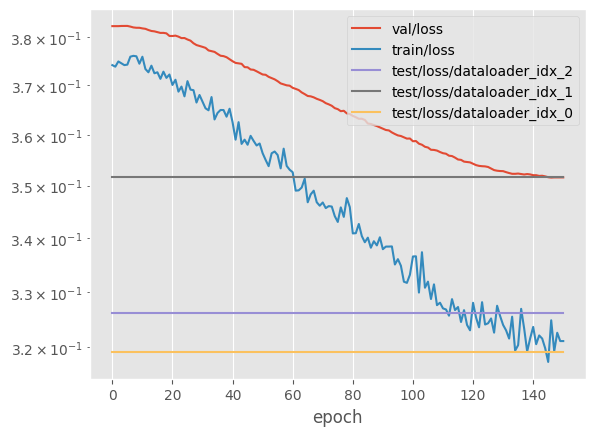

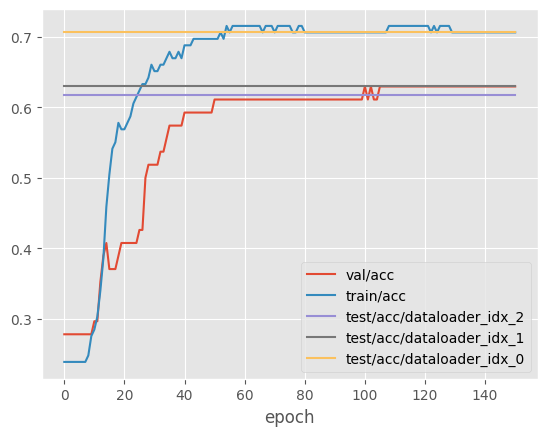

In [26]:
# look at hist
df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
for key in ['loss']:
    df_hist[[c for c in df_hist.columns if key in c]].plot(logy=True)
    
for key in ['acc']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()
df_hist